#### Import libraries and packages

In [1]:
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.utils import column_or_1d

warnings.filterwarnings('ignore')

#### Import dataset

In [2]:
df = pd.read_csv("C:\\Users\\DNV\\OneDrive\\Desktop\\Data-Gold.csv",parse_dates=True,index_col=0)

#### Create a new Timestamp column for time series forecasting

In [3]:
df['Timestamp'] = pd.to_datetime(df.index).astype(np.int64) / 10**9
df_index = df.index
df_open = df['VND'].values.reshape(-1, 1)
df.head()

,VND,Timestamp
Date,,
2012-01-02,32202288.50,1.325462e+09
2012-01-03,33607538.00,1.325549e+09
2012-01-04,33923003.00,1.325635e+09
2012-01-05,33628569.00,1.325722e+09
2012-01-06,34000652.75,1.325808e+09


#### Plotting Gold price chart

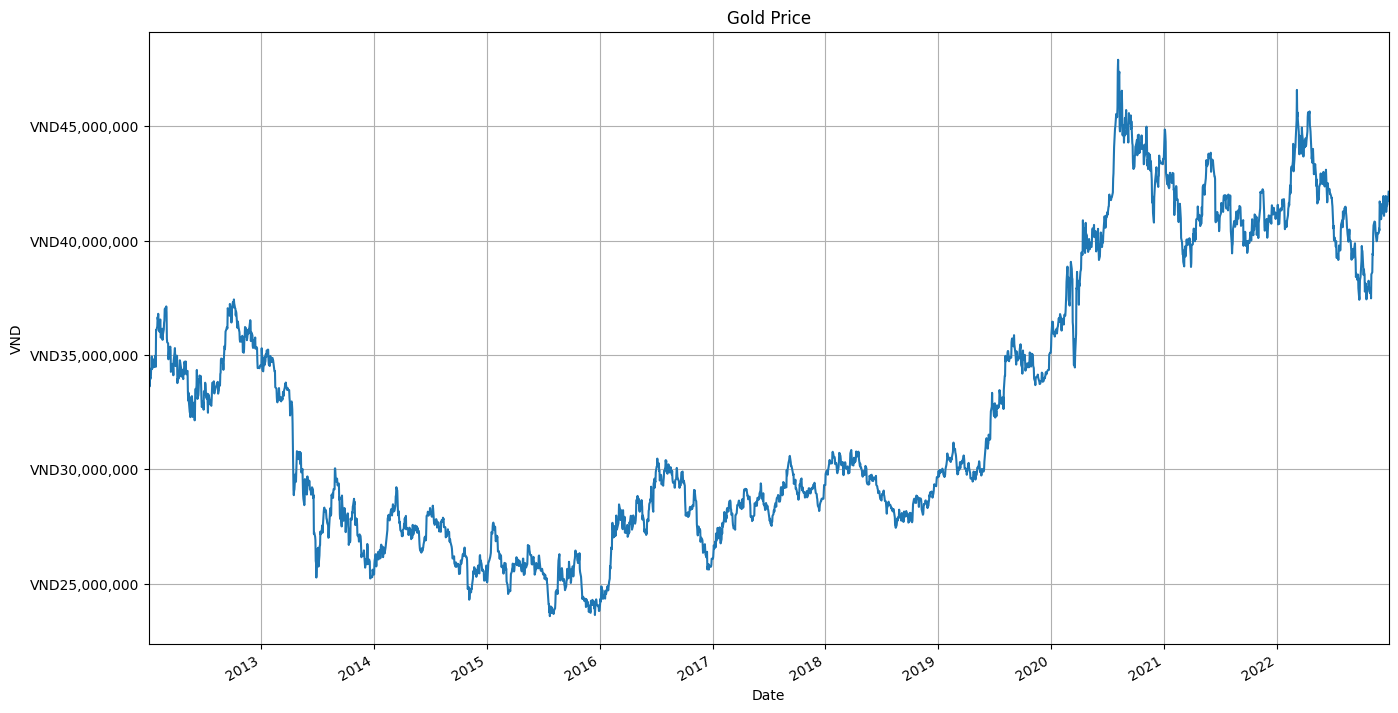

In [4]:
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('VND{x:,.0f}')

title = 'Gold Price'
ylabel = 'VND'
xlabel = 'Date'

ax = df['VND'].plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

#### Normalizing / scaling data to facilitate model building

In [5]:
LR_sc = StandardScaler()

df_scaled = df.copy()
df_scaled['VND'] = LR_sc.fit_transform(df_open)
df_scaled

,VND,Timestamp
Date,,
2012-01-02,-0.062575,1.325462e+09
2012-01-03,0.167826,1.325549e+09
2012-01-04,0.219549,1.325635e+09
2012-01-05,0.171274,1.325722e+09
2012-01-06,0.232280,1.325808e+09
...,...,...
2022-12-26,1.476100,1.672013e+09
2022-12-27,1.526588,1.672099e+09
2022-12-28,1.499084,1.672186e+09


In [6]:
X_sc = StandardScaler()
y_sc = StandardScaler()

X = df.iloc[:, 1].values.reshape(-1, 1)
y = df.iloc[:, 0].values.reshape(-1, 1)


X_scaled = X_sc.fit_transform(X)
y_scaled = y_sc.fit_transform(y)


df_scaled = pd.DataFrame(index=df_index)
df_scaled['Timestamp'] = X_scaled
df_scaled['VND'] = y_scaled
df_scaled.head()

,Timestamp,VND
Date,,
2012-01-02,-1.730686,-0.062575
2012-01-03,-1.729824,0.167826
2012-01-04,-1.728962,0.219549
2012-01-05,-1.728100,0.171274
2012-01-06,-1.727237,0.232280


#### Split data for training and testing ( 7-3 )

In [7]:
interrupt = int(len(df_scaled) * .7)

train_data, test_data = df_scaled[:interrupt], df_scaled[interrupt:]
index_test = df_scaled.index[interrupt:]
print(train_data.shape)
print(test_data.shape)

(2008, 2)
(862, 2)


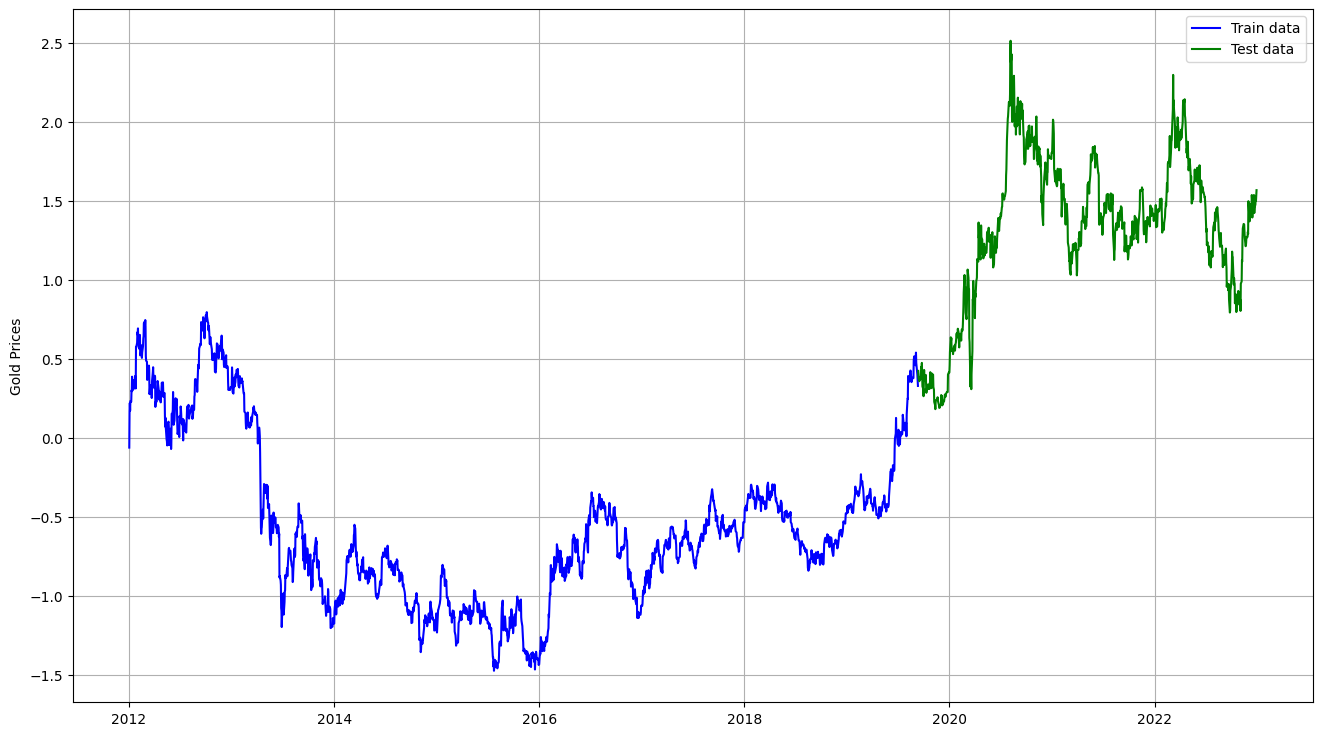

In [8]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Gold Prices')
plt.plot(train_data['VND'], 'blue', label='Train data')
plt.plot(test_data['VND'], 'green', label='Test data')
plt.legend()

#### Determine the independent variable (X) and the dependent variable (y).

In [9]:
X_train = train_data['Timestamp'].values.reshape(-1, 1)
y_train = train_data['VND'].values.reshape(-1, 1)

X_test = test_data['Timestamp'].values.reshape(-1, 1)
y_test = test_data['VND'].values.reshape(-1, 1)

#### The function that creates Hyperparameters 

In [10]:
def para_range(minimum, maximum, step):
    para_list = np.arange(minimum, maximum, step)
    return para_list


#### The function that outputs the results of each case in GridSearch

In [11]:
def print_stats(hyperparams, stats):
    if(hyperparams[0] == 'poly'):
        print(
            f'SVR(kernel={hyperparams[0]}, C={hyperparams[1]}, gamma={hyperparams[2]}, degree={hyperparams[3]}')
    else:
        print(
            f'SVR(kernel={hyperparams[0]}, C={hyperparams[1]}, gamma={hyperparams[2]}')

    print(
        f"MAE={stats[0]:.2f} | MAPE={stats[1]:.2f} | MSE={stats[2] :.2f} | RMSE={stats[3]:.2f}")


#### Generate values for the hyperparameters

In [12]:
kernels = ['sigmoid', 'rbf', 'poly']
Cs = para_range(0.01, 0.2, 0.1)
gammas = para_range(0.1, 5, 0.1)
degrees = para_range(1, 6, 1)


#### GridSearch to find suitable hyperparameters

In [13]:
warnings.filterwarnings('ignore')

stats_df = pd.DataFrame(
    columns=['kernel', 'C', 'gamma', 'degree', 'MAE', 'MAPE', 'MSE', 'RMSE'])

# GridSearch to find suitable hyperparameters
for ker in kernels:
    # If that is = = poly, make a choice degree.
    if(ker != 'poly'):
        for C in Cs:
            for gamma in gammas:
                rgs = SVR(kernel=ker, C=C, gamma=gamma, verbose=False)
                rgs.fit(X_train, y_train)
                pred = rgs.predict(X_test)

                # Transform back to original form
                inv_pred = y_sc.inverse_transform(
                    column_or_1d(pred).reshape(-1, 1))
                inv_test = y_sc.inverse_transform(
                    column_or_1d(y_test).reshape(-1, 1))
                    
                # Model Evaluation
                mae = mean_absolute_error(inv_test, inv_pred)
                mape = mean_absolute_percentage_error(inv_test, inv_pred)
                mse = mean_squared_error(inv_test, inv_pred)
                rmse = np.sqrt(mse)

                result = {'kernel': ker, 'C': C, 'gamma': gamma, 'degree': 0,
                          'MAE': mae, 'MAPE': mape, 'MSE': mse, 'RMSE': rmse}

                hyperparam = [ker, C, gamma, 0]
                stats = [mae, mape, mse, rmse]
                stats_df = stats_df.append(result, ignore_index=True)
                print_stats(hyperparam, stats)
    else:
        for C in Cs:
            for gamma in gammas:
                for deg in degrees:
                    rgs = SVR(kernel=ker, C=C, gamma=gamma, degree=deg, verbose=False)
                    rgs.fit(X_train, y_train.reshape(-1, 1))
                    pred = rgs.predict(X_test)

                    # Transform back to original form
                    inv_pred = y_sc.inverse_transform(
                        column_or_1d(pred).reshape(-1, 1))
                    inv_test = y_sc.inverse_transform(
                        column_or_1d(y_test).reshape(-1, 1))

                    # Model Evaluation
                    mae = mean_absolute_error(inv_test, inv_pred)
                    mape = mean_absolute_percentage_error(inv_test, inv_pred)
                    mse = mean_squared_error(inv_test, inv_pred)
                    rmse = np.sqrt(mse)

                    result = {'kernel': ker, 'C': C, 'gamma': gamma, 'degree': deg,
                            'MAE': mae, 'MAPE': mape, 'MSE': mse, 'RMSE': rmse}

                    hyperparam = [ker, C, gamma, deg]
                    stats = [mae, mape, mse, rmse]

                    stats_df = stats_df.append(result, ignore_index=True)

                    print_stats(hyperparam, stats)


SVR(kernel=sigmoid, C=0.01, gamma=0.1
MAE=11668682.86 | MAPE=0.28 | MSE=144560633435375.34 | RMSE=12023337.03
SVR(kernel=sigmoid, C=0.01, gamma=0.2
MAE=11424492.79 | MAPE=0.28 | MSE=138729440510280.83 | RMSE=11778346.26
SVR(kernel=sigmoid, C=0.01, gamma=0.30000000000000004
MAE=11043936.92 | MAPE=0.27 | MSE=129938498170758.14 | RMSE=11399056.90
SVR(kernel=sigmoid, C=0.01, gamma=0.4
MAE=10469023.77 | MAPE=0.25 | MSE=117474059046297.08 | RMSE=10838545.06
SVR(kernel=sigmoid, C=0.01, gamma=0.5
MAE=9719421.37 | MAPE=0.24 | MSE=102698858124695.42 | RMSE=10134044.51
SVR(kernel=sigmoid, C=0.01, gamma=0.6
MAE=8874550.78 | MAPE=0.22 | MSE=88018630658062.44 | RMSE=9381824.48
SVR(kernel=sigmoid, C=0.01, gamma=0.7000000000000001
MAE=7866658.92 | MAPE=0.19 | MSE=72882928832548.22 | RMSE=8537149.92
SVR(kernel=sigmoid, C=0.01, gamma=0.8
MAE=6784038.47 | MAPE=0.17 | MSE=58194177254616.73 | RMSE=7628510.82
SVR(kernel=sigmoid, C=0.01, gamma=0.9
MAE=5860669.21 | MAPE=0.14 | MSE=45614081590878.62 | RMSE=675

SVR(kernel=sigmoid, C=0.11, gamma=2.4000000000000004
MAE=134793311.44 | MAPE=3.29 | MSE=20687963935609580.00 | RMSE=143833111.40
SVR(kernel=sigmoid, C=0.11, gamma=2.5000000000000004
MAE=136334830.63 | MAPE=3.33 | MSE=21019172174263748.00 | RMSE=144979902.66
SVR(kernel=sigmoid, C=0.11, gamma=2.6
MAE=138078371.49 | MAPE=3.37 | MSE=21411996102763840.00 | RMSE=146328384.47
SVR(kernel=sigmoid, C=0.11, gamma=2.7
MAE=138982392.33 | MAPE=3.40 | MSE=21573392881877036.00 | RMSE=146878837.42
SVR(kernel=sigmoid, C=0.11, gamma=2.8000000000000003
MAE=139961523.74 | MAPE=3.42 | MSE=21765754444351584.00 | RMSE=147532214.94
SVR(kernel=sigmoid, C=0.11, gamma=2.9000000000000004
MAE=140547812.81 | MAPE=3.44 | MSE=21851925493966196.00 | RMSE=147823967.93
SVR(kernel=sigmoid, C=0.11, gamma=3.0000000000000004
MAE=141456550.19 | MAPE=3.46 | MSE=22030491000213988.00 | RMSE=148426719.29
SVR(kernel=sigmoid, C=0.11, gamma=3.1
MAE=142499930.78 | MAPE=3.49 | MSE=22253170061165308.00 | RMSE=149174964.59
SVR(kernel=si

SVR(kernel=rbf, C=0.01, gamma=4.7
MAE=10043454.55 | MAPE=0.24 | MSE=110487192547657.08 | RMSE=10511288.81
SVR(kernel=rbf, C=0.01, gamma=4.8
MAE=10055049.95 | MAPE=0.24 | MSE=110767333404519.55 | RMSE=10524606.09
SVR(kernel=rbf, C=0.01, gamma=4.9
MAE=10066733.54 | MAPE=0.24 | MSE=111051745201193.42 | RMSE=10538109.19
SVR(kernel=rbf, C=0.11, gamma=0.1
MAE=4977650.25 | MAPE=0.12 | MSE=32519948777597.31 | RMSE=5702626.48
SVR(kernel=rbf, C=0.11, gamma=0.2
MAE=6195898.68 | MAPE=0.15 | MSE=44979252738049.28 | RMSE=6706657.34
SVR(kernel=rbf, C=0.11, gamma=0.30000000000000004
MAE=8664772.63 | MAPE=0.21 | MSE=82731218242834.67 | RMSE=9095670.30
SVR(kernel=rbf, C=0.11, gamma=0.4
MAE=9506189.64 | MAPE=0.23 | MSE=98618838972517.64 | RMSE=9930701.84
SVR(kernel=rbf, C=0.11, gamma=0.5
MAE=9318239.48 | MAPE=0.23 | MSE=94787498337674.59 | RMSE=9735887.14
SVR(kernel=rbf, C=0.11, gamma=0.6
MAE=8857760.90 | MAPE=0.21 | MSE=86007074209235.98 | RMSE=9273999.90
SVR(kernel=rbf, C=0.11, gamma=0.7000000000000001

SVR(kernel=poly, C=0.01, gamma=0.5, degree=2
MAE=9666955.34 | MAPE=0.23 | MSE=101310481528169.05 | RMSE=10065310.80
SVR(kernel=poly, C=0.01, gamma=0.5, degree=3
MAE=15214196.68 | MAPE=0.37 | MSE=245906420852215.75 | RMSE=15681403.66
SVR(kernel=poly, C=0.01, gamma=0.5, degree=4
MAE=10076279.79 | MAPE=0.24 | MSE=112105226185078.81 | RMSE=10587975.55
SVR(kernel=poly, C=0.01, gamma=0.5, degree=5
MAE=14885831.78 | MAPE=0.36 | MSE=237572486846258.56 | RMSE=15413386.61
SVR(kernel=poly, C=0.01, gamma=0.6, degree=1
MAE=11503790.21 | MAPE=0.28 | MSE=140681383463794.92 | RMSE=11860918.32
SVR(kernel=poly, C=0.01, gamma=0.6, degree=2
MAE=9589307.10 | MAPE=0.23 | MSE=99865470811140.34 | RMSE=9993271.28
SVR(kernel=poly, C=0.01, gamma=0.6, degree=3
MAE=15344258.93 | MAPE=0.37 | MSE=250194312539061.69 | RMSE=15817531.81
SVR(kernel=poly, C=0.01, gamma=0.6, degree=4
MAE=10055034.00 | MAPE=0.24 | MSE=111818145193491.45 | RMSE=10574409.92
SVR(kernel=poly, C=0.01, gamma=0.6, degree=5
MAE=14989754.98 | MAPE=

SVR(kernel=poly, C=0.01, gamma=1.8000000000000003, degree=5
MAE=15059923.70 | MAPE=0.37 | MSE=243442339317512.16 | RMSE=15602638.86
SVR(kernel=poly, C=0.01, gamma=1.9000000000000001, degree=1
MAE=11460472.96 | MAPE=0.28 | MSE=139671563448022.20 | RMSE=11818272.44
SVR(kernel=poly, C=0.01, gamma=1.9000000000000001, degree=2
MAE=9457037.43 | MAPE=0.23 | MSE=97461907364904.47 | RMSE=9872279.75
SVR(kernel=poly, C=0.01, gamma=1.9000000000000001, degree=3
MAE=15493871.68 | MAPE=0.38 | MSE=255164708819868.41 | RMSE=15973875.82
SVR(kernel=poly, C=0.01, gamma=1.9000000000000001, degree=4
MAE=10038019.49 | MAPE=0.24 | MSE=111636563123784.75 | RMSE=10565820.51
SVR(kernel=poly, C=0.01, gamma=1.9000000000000001, degree=5
MAE=15055117.05 | MAPE=0.37 | MSE=243286811469458.03 | RMSE=15597654.04
SVR(kernel=poly, C=0.01, gamma=2.0, degree=1
MAE=11455566.76 | MAPE=0.28 | MSE=139553755678735.05 | RMSE=11813287.25
SVR(kernel=poly, C=0.01, gamma=2.0, degree=2
MAE=9458192.63 | MAPE=0.23 | MSE=97483757869101.0

SVR(kernel=poly, C=0.01, gamma=3.2, degree=3
MAE=15495872.97 | MAPE=0.38 | MSE=255230511253086.97 | RMSE=15975935.38
SVR(kernel=poly, C=0.01, gamma=3.2, degree=4
MAE=10038001.06 | MAPE=0.24 | MSE=111636244304684.88 | RMSE=10565805.43
SVR(kernel=poly, C=0.01, gamma=3.2, degree=5
MAE=15058916.83 | MAPE=0.37 | MSE=243412457749398.56 | RMSE=15601681.25
SVR(kernel=poly, C=0.01, gamma=3.3000000000000003, degree=1
MAE=11455566.53 | MAPE=0.28 | MSE=139553750120473.95 | RMSE=11813287.02
SVR(kernel=poly, C=0.01, gamma=3.3000000000000003, degree=2
MAE=9452006.46 | MAPE=0.23 | MSE=97375426369449.19 | RMSE=9867898.78
SVR(kernel=poly, C=0.01, gamma=3.3000000000000003, degree=3
MAE=15493879.43 | MAPE=0.38 | MSE=255164975643419.19 | RMSE=15973884.18
SVR(kernel=poly, C=0.01, gamma=3.3000000000000003, degree=4
MAE=10037920.25 | MAPE=0.24 | MSE=111634843575014.64 | RMSE=10565739.14
SVR(kernel=poly, C=0.01, gamma=3.3000000000000003, degree=5
MAE=15059418.46 | MAPE=0.37 | MSE=243428786896149.00 | RMSE=1560

SVR(kernel=poly, C=0.01, gamma=4.5, degree=5
MAE=15063309.53 | MAPE=0.37 | MSE=243553603983085.00 | RMSE=15606204.02
SVR(kernel=poly, C=0.01, gamma=4.6, degree=1
MAE=11441883.81 | MAPE=0.28 | MSE=139234658277732.64 | RMSE=11799773.65
SVR(kernel=poly, C=0.01, gamma=4.6, degree=2
MAE=9452933.47 | MAPE=0.23 | MSE=97392953174850.45 | RMSE=9868786.81
SVR(kernel=poly, C=0.01, gamma=4.6, degree=3
MAE=15493917.38 | MAPE=0.38 | MSE=255166282294276.03 | RMSE=15973925.07
SVR(kernel=poly, C=0.01, gamma=4.6, degree=4
MAE=10038016.86 | MAPE=0.24 | MSE=111636517369569.75 | RMSE=10565818.35
SVR(kernel=poly, C=0.01, gamma=4.6, degree=5
MAE=15064464.84 | MAPE=0.37 | MSE=243600108516525.69 | RMSE=15607693.89
SVR(kernel=poly, C=0.01, gamma=4.7, degree=1
MAE=11441883.68 | MAPE=0.28 | MSE=139234655301798.34 | RMSE=11799773.53
SVR(kernel=poly, C=0.01, gamma=4.7, degree=2
MAE=9452366.84 | MAPE=0.23 | MSE=97383164966115.12 | RMSE=9868290.88
SVR(kernel=poly, C=0.01, gamma=4.7, degree=3
MAE=15493680.90 | MAPE=0.

SVR(kernel=poly, C=0.11, gamma=1.1, degree=1
MAE=11441883.76 | MAPE=0.28 | MSE=139234657051663.44 | RMSE=11799773.60
SVR(kernel=poly, C=0.11, gamma=1.1, degree=2
MAE=9452932.35 | MAPE=0.23 | MSE=97392932704884.64 | RMSE=9868785.78
SVR(kernel=poly, C=0.11, gamma=1.1, degree=3
MAE=15494694.91 | MAPE=0.38 | MSE=255190222363112.81 | RMSE=15974674.41
SVR(kernel=poly, C=0.11, gamma=1.1, degree=4
MAE=10038027.71 | MAPE=0.24 | MSE=111636705508576.08 | RMSE=10565827.25
SVR(kernel=poly, C=0.11, gamma=1.1, degree=5
MAE=15061314.26 | MAPE=0.37 | MSE=243487401692014.22 | RMSE=15604082.85
SVR(kernel=poly, C=0.11, gamma=1.2000000000000002, degree=1
MAE=11441883.09 | MAPE=0.28 | MSE=139234641534244.81 | RMSE=11799772.94
SVR(kernel=poly, C=0.11, gamma=1.2000000000000002, degree=2
MAE=9452005.17 | MAPE=0.23 | MSE=97375401807561.61 | RMSE=9867897.54
SVR(kernel=poly, C=0.11, gamma=1.2000000000000002, degree=3
MAE=15493870.73 | MAPE=0.38 | MSE=255164676139351.19 | RMSE=15973874.80
SVR(kernel=poly, C=0.11, 

SVR(kernel=poly, C=0.11, gamma=2.4000000000000004, degree=2
MAE=9452367.63 | MAPE=0.23 | MSE=97383184683837.92 | RMSE=9868291.88
SVR(kernel=poly, C=0.11, gamma=2.4000000000000004, degree=3
MAE=15493861.91 | MAPE=0.38 | MSE=255164372519135.84 | RMSE=15973865.30
SVR(kernel=poly, C=0.11, gamma=2.4000000000000004, degree=4
MAE=10038158.31 | MAPE=0.24 | MSE=111640833290187.64 | RMSE=10566022.59
SVR(kernel=poly, C=0.11, gamma=2.4000000000000004, degree=5
MAE=15058873.60 | MAPE=0.37 | MSE=243411706707081.16 | RMSE=15601657.18
SVR(kernel=poly, C=0.11, gamma=2.5000000000000004, degree=1
MAE=11422288.03 | MAPE=0.28 | MSE=138780306132885.70 | RMSE=11780505.34
SVR(kernel=poly, C=0.11, gamma=2.5000000000000004, degree=2
MAE=9452932.47 | MAPE=0.23 | MSE=97392934844034.58 | RMSE=9868785.89
SVR(kernel=poly, C=0.11, gamma=2.5000000000000004, degree=3
MAE=15493801.45 | MAPE=0.38 | MSE=255162289693187.56 | RMSE=15973800.10
SVR(kernel=poly, C=0.11, gamma=2.5000000000000004, degree=4
MAE=10038006.77 | MAPE

SVR(kernel=poly, C=0.11, gamma=3.7, degree=3
MAE=15493971.79 | MAPE=0.38 | MSE=255168161332219.62 | RMSE=15973983.89
SVR(kernel=poly, C=0.11, gamma=3.7, degree=4
MAE=10041574.27 | MAPE=0.24 | MSE=111710573338882.08 | RMSE=10569322.27
SVR(kernel=poly, C=0.11, gamma=3.7, degree=5
MAE=15064825.53 | MAPE=0.37 | MSE=243597946032412.88 | RMSE=15607624.61
SVR(kernel=poly, C=0.11, gamma=3.8000000000000003, degree=1
MAE=11416783.75 | MAPE=0.28 | MSE=138652139503886.33 | RMSE=11775064.31
SVR(kernel=poly, C=0.11, gamma=3.8000000000000003, degree=2
MAE=9449919.29 | MAPE=0.23 | MSE=97340150003695.23 | RMSE=9866111.19
SVR(kernel=poly, C=0.11, gamma=3.8000000000000003, degree=3
MAE=15493839.49 | MAPE=0.38 | MSE=255163578734903.69 | RMSE=15973840.45
SVR(kernel=poly, C=0.11, gamma=3.8000000000000003, degree=4
MAE=10037653.62 | MAPE=0.24 | MSE=111628889659849.19 | RMSE=10565457.38
SVR(kernel=poly, C=0.11, gamma=3.8000000000000003, degree=5
MAE=15064123.49 | MAPE=0.37 | MSE=243579111092975.53 | RMSE=1560

#### Find the optimal parameters for the model

In [14]:
best_fit_model = stats_df[stats_df['MAPE'] == stats_df['MAPE'].min()].head(1)
best_fit_model


,kernel,C,gamma,degree,MAE,MAPE,MSE,RMSE
48,sigmoid,0.01,4.9,0,3.083792e+06,0.076903,1.391556e+13,3.730357e+06


#### Super vector regression - SVR

In [15]:
kernel = str(best_fit_model['kernel'].values[0])
C = float(best_fit_model['C'])
gamma = float(best_fit_model['gamma'])
degree = int(best_fit_model['degree'])

if(kernel == 'poly'):
    rgs = SVR(kernel=kernel, C=C, gamma=gamma, degree=degree)
else:
    rgs = SVR(kernel=kernel, C=C, gamma=gamma)
    
rgs.fit(X_train, y_train.reshape(-1, 1))
pred = rgs.predict(X_test)
pred

array([0.57431373, 0.57751186, 0.58707373, 0.59025022, 0.59342131,
       0.59658703, 0.59974738, 0.60919635, 0.61233534, 0.61546902,
       0.61859739, 0.62172047, 0.63105804, 0.63416004, 0.6372568 ,
       0.64034833, 0.64343463, 0.65266231, 0.65572782, 0.65878816,
       0.66184334, 0.66489336, 0.67401262, 0.67704214, 0.68006655,
       0.68308587, 0.68610011, 0.69511242, 0.69810643, 0.7010954 ,
       0.70407935, 0.70705829, 0.71596511, 0.71892409, 0.72187811,
       0.72482717, 0.72777129, 0.73657406, 0.7394985 , 0.74241804,
       0.74533268, 0.74824246, 0.75694261, 0.75983297, 0.7627185 ,
       0.76559921, 0.7684751 , 0.77707403, 0.77993079, 0.78278278,
       0.78563001, 0.7884725 , 0.7969716 , 0.79979521, 0.80261412,
       0.80542834, 0.80823789, 0.81663853, 0.81942945, 0.82221574,
       0.8249974 , 0.82777445, 0.836078  , 0.83883668, 0.8415908 ,
       0.84434035, 0.84708535, 0.85529315, 0.85802004, 0.86074243,
       0.86346031, 0.86617371, 0.87428708, 0.87698262, 0.87967

#### Transform back to original form

In [16]:
inv_pred = y_sc.inverse_transform(
    column_or_1d(pred).reshape(-1, 1))
inv_test = y_sc.inverse_transform(
    column_or_1d(y_test).reshape(-1, 1))

#### Graph the test set and the prediction results

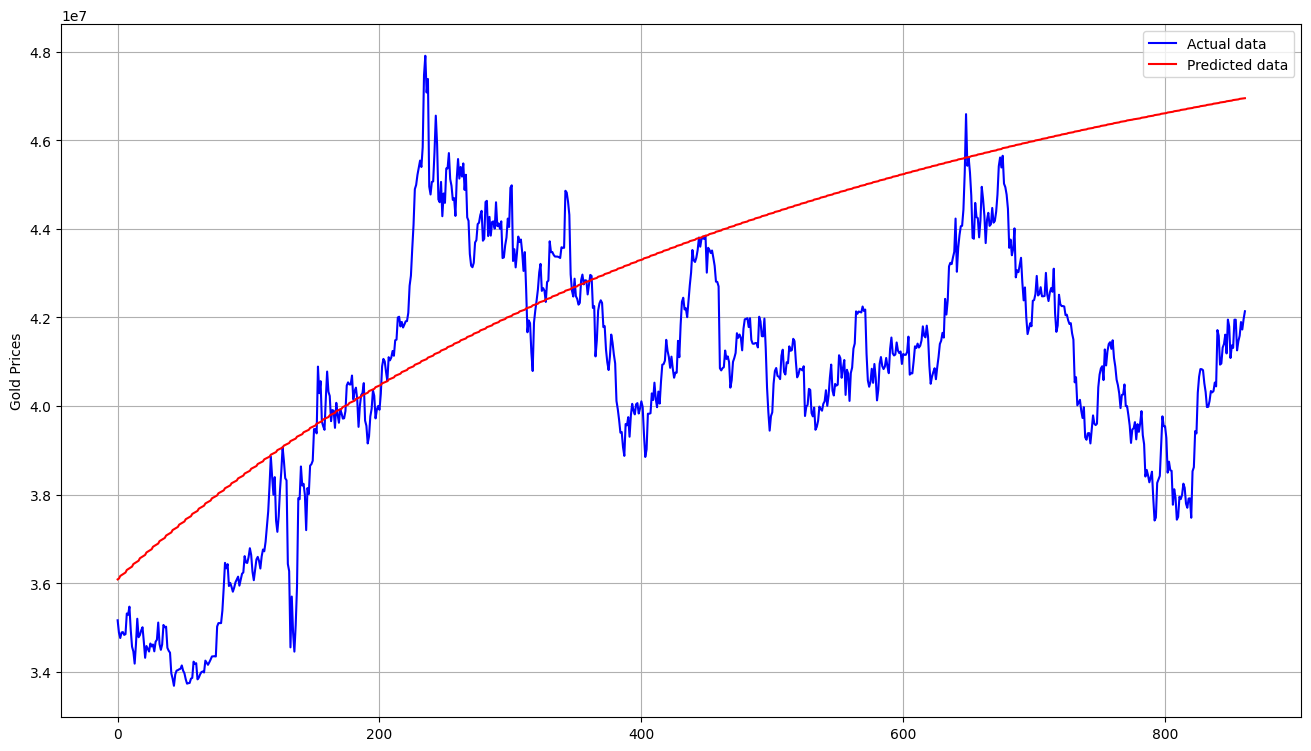

In [17]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Gold Prices')
plt.plot(column_or_1d(inv_test), 'blue', label='Actual data')
plt.plot(column_or_1d(inv_pred), 'red', label='Predicted data')
plt.legend()

#### Model Evaluation

In [19]:
from sklearn.metrics import r2_score
mae = mean_absolute_error(inv_test, inv_pred) 
mape = mean_absolute_percentage_error(inv_test, inv_pred)
mse = mean_squared_error(inv_test, inv_pred) 
rmse = np.sqrt(mse) 
r2 = r2_score(inv_test, inv_pred)
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 3083792.05
MAPE: 7.69%
MSE: 13915560011923.34
RMSE: 3730356.55
R2: -0.62
